In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,StratifiedKFold,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import metrics

In [4]:
animal_data = pd.read_csv("animal_data_clean.csv")
animal_data.head()

,Group,A_C1W1T0,A_C2W1T0,L_C1W1T0,L_C2W1T0,A_C1W2T0,A_C2W2T0,L_C1W2T0,L_C2W2T0,A_C1W3T0,...,rC_C2W3T2,lC_C2W4T2,cC_C2W4T2,rC_C2W4T2,lC_C2W5T2,cC_C2W5T2,rC_C2W5T2,Level_70_70,Level_70_90,Level_90_90
0,0,0.000002,0.000003,1.352459,11.270492,0.000005,0.000006,2.090164,12.008197,0.000004,...,0.000258,0.000033,0.000092,0.000078,0.000058,0.000031,0.000016,True,False,False
1,0,0.000002,0.000005,1.311475,11.188525,0.000005,0.000008,2.008197,11.885246,0.000004,...,0.000228,0.000090,0.000122,0.000080,0.000059,0.000041,0.000010,False,True,False
2,0,0.000004,0.000004,1.311475,11.229508,0.000008,0.000008,2.049180,12.008197,0.000006,...,0.000209,0.000104,0.000096,0.000037,0.000078,0.000073,0.000030,False,False,True
3,0,0.000006,0.000006,1.352459,11.270492,0.000005,0.000006,2.131148,12.049180,0.000004,...,0.000091,0.000044,0.000081,0.000074,0.000026,0.000055,0.000030,True,False,False
4,0,0.000005,0.000010,1.311475,11.188525,0.000006,0.000008,2.049180,11.926230,0.000004,...,0.000140,0.000084,0.000098,0.000063,0.000033,0.000022,0.000017,False,True,False


### Data Split and Normalization

In [5]:
Y = animal_data['Group']
X = animal_data.drop(['Group'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)

In [5]:
y_train.value_counts()

Group
0    72
2    60
1    14
Name: count, dtype: int64

In [6]:
y_test.value_counts()

Group
0    18
2    15
1     4
Name: count, dtype: int64

In [6]:
minmax = MinMaxScaler()
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train_normalized = X_train.copy()  
X_train_normalized[numeric_columns] = minmax.fit_transform(X_train[numeric_columns])

# Transform the testing data using the same scaler to avoid data leakage
X_test_normalized = X_test.copy()  
X_test_normalized[numeric_columns] = minmax.transform(X_test[numeric_columns])

### Cross validation

In [8]:
skf = StratifiedKFold(n_splits=5)
for i,(train_index,val_index) in enumerate(skf.split(X_train_normalized,y_train)):
    print('\nFold:',i)
    ## compute the number of datapoints for each class 
    X_train_fold = X_train_normalized.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_val_fold = X_train_normalized.iloc[val_index]
    y_val_fold = y_train.iloc[val_index]

    print('\ntraining counts:',y_train_fold.value_counts())
    print('\nvalidation counts:',y_val_fold.value_counts())



Fold: 0

training counts: Group
0    57
2    48
1    11
Name: count, dtype: int64

validation counts: Group
0    15
2    12
1     3
Name: count, dtype: int64

Fold: 1

training counts: Group
0    57
2    48
1    12
Name: count, dtype: int64

validation counts: Group
0    15
2    12
1     2
Name: count, dtype: int64

Fold: 2

training counts: Group
0    58
2    48
1    11
Name: count, dtype: int64

validation counts: Group
0    14
2    12
1     3
Name: count, dtype: int64

Fold: 3

training counts: Group
0    58
2    48
1    11
Name: count, dtype: int64

validation counts: Group
0    14
2    12
1     3
Name: count, dtype: int64

Fold: 4

training counts: Group
0    58
2    48
1    11
Name: count, dtype: int64

validation counts: Group
0    14
2    12
1     3
Name: count, dtype: int64


### Hyperparameters
1. C - regularization term [100,10,1,0.1,0.01,0.001]
4. Solver = {newton-cg,saga,lbfgs}

In [27]:
c_values = [1000000,10000,1000,500,100,10,1,0.1,0.01,0.001]
solvers = ['newton-cg','saga','lbfgs']

### Training

In [28]:
skf_cv = StratifiedKFold(n_splits=5)
grid_result_list = []

In [29]:
## implementing grid search for including custom metrics
for c in c_values:
    for solver in solvers:
        grid_result = {}
        grid_result['C'] = c
        grid_result['solver'] = solver
        
        for i,(train_index,test_index) in enumerate(skf.split(X_train_normalized,y_train)):
            train_features, train_label = X_train_normalized.iloc[train_index], y_train.iloc[train_index]
            test_features, test_label = X_train_normalized.iloc[test_index], y_train.iloc[test_index]

            ## define model 
            lr_classifier = LogisticRegression(solver=solver,random_state=42,C=c)  ## setting the random_state for reproducability
            lr_classifier.fit(train_features,train_label)

            ypred = lr_classifier.predict(test_features)
            lr_metrics = metrics.metrics(test_label,ypred)
            precisions,recalls,f1_scores,macro_f1,weighted_f1 = lr_metrics.f1_score()
            acc = lr_metrics.compute_accuracy()

            grid_result[f'accuracy_fold{i}'] = acc
            grid_result[f'f1_scores_fold{i}'] = f1_scores
            grid_result[f'macro_f1_fold{i}'] = macro_f1
            grid_result[f'weighted_f1_fold{i}'] = weighted_f1
            
        ##compute the average values
        grid_result['avg_acc'] = 0.2*sum([grid_result[f'accuracy_fold{i}'] for i in np.arange(5)])
        grid_result['avg_weighted_f1'] = 0.2*sum([grid_result[f'weighted_f1_fold{i}'] for i in np.arange(5)])
        grid_result['avg_macro_f1'] = 0.2*sum([grid_result[f'macro_f1_fold{i}'] for i in np.arange(5)])
        grid_result_list.append(grid_result)


            

c:\Users\medha\anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\medha\anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\medha\anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\medha\anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\medha\anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\medha\anaconda3\envs\pytorch\lib\sit

In [30]:
grid_df = pd.DataFrame(grid_result_list)
grid_df

,C,solver,accuracy_fold0,f1_scores_fold0,macro_f1_fold0,weighted_f1_fold0,accuracy_fold1,f1_scores_fold1,macro_f1_fold1,weighted_f1_fold1,...,f1_scores_fold3,macro_f1_fold3,weighted_f1_fold3,accuracy_fold4,f1_scores_fold4,macro_f1_fold4,weighted_f1_fold4,avg_acc,avg_weighted_f1,avg_macro_f1
0,1000000.000,newton-cg,0.800000,"[0.846153846153846, 0.5, 0.8461538461538461]",0.730769,0.653846,0.896552,"[0.896551724137931, 0.4, 1.0]",0.765517,0.829489,...,"[0.9333333333333333, 0.8, 0.9565217391304348]",0.896618,0.868566,0.931034,"[0.9285714285714286, 0.6666666666666666, 1.0]",0.865079,0.876026,0.884138,0.798609,0.799809
1,1000000.000,saga,0.766667,"[0.8, 0.5714285714285715, 0.7857142857142857]",0.719048,0.592857,0.931034,"[0.9333333333333333, 0.5, 1.0]",0.811111,0.881609,...,"[0.9333333333333333, 0.8, 0.9565217391304348]",0.896618,0.868566,0.965517,"[0.9655172413793104, 0.8, 1.0]",0.921839,0.935077,0.905057,0.831944,0.831945
2,1000000.000,lbfgs,0.766667,"[0.8, 0.5714285714285715, 0.7857142857142857]",0.719048,0.592857,0.896552,"[0.9333333333333333, 0.4, 0.9565217391304348]",0.763285,0.827186,...,"[0.9333333333333333, 0.8, 0.9565217391304348]",0.896618,0.868566,0.965517,"[0.9655172413793104, 0.8, 1.0]",0.921839,0.935077,0.905057,0.831753,0.844526
3,10000.000,newton-cg,0.800000,"[0.846153846153846, 0.5, 0.8461538461538461]",0.730769,0.653846,0.896552,"[0.896551724137931, 0.4, 1.0]",0.765517,0.829489,...,"[0.9333333333333333, 0.8, 0.9565217391304348]",0.896618,0.868566,0.931034,"[0.9285714285714286, 0.6666666666666666, 1.0]",0.865079,0.876026,0.877241,0.786235,0.794784
4,10000.000,saga,0.766667,"[0.8, 0.5714285714285715, 0.7857142857142857]",0.719048,0.592857,0.931034,"[0.9333333333333333, 0.5, 1.0]",0.811111,0.881609,...,"[0.9333333333333333, 0.8, 0.9565217391304348]",0.896618,0.868566,0.965517,"[0.9655172413793104, 0.8, 1.0]",0.921839,0.935077,0.905057,0.831944,0.831945
5,10000.000,lbfgs,0.800000,"[0.846153846153846, 0.5, 0.8461538461538461]",0.730769,0.653846,0.896552,"[0.896551724137931, 0.4, 1.0]",0.765517,0.829489,...,"[0.9333333333333333, 0.8, 0.9565217391304348]",0.896618,0.868566,0.931034,"[0.9285714285714286, 0.6666666666666666, 1.0]",0.865079,0.876026,0.884138,0.798609,0.799809
6,1000.000,newton-cg,0.800000,"[0.846153846153846, 0.5, 0.8461538461538461]",0.730769,0.653846,0.896552,"[0.896551724137931, 0.4, 1.0]",0.765517,0.829489,...,"[0.9333333333333333, 0.8, 0.9565217391304348]",0.896618,0.868566,0.931034,"[0.9285714285714286, 0.6666666666666666, 1.0]",0.865079,0.876026,0.877241,0.786235,0.794784
7,1000.000,saga,0.766667,"[0.8, 0.5714285714285715, 0.7857142857142857]",0.719048,0.592857,0.931034,"[0.9333333333333333, 0.5, 1.0]",0.811111,0.881609,...,"[0.9333333333333333, 0.8, 0.9565217391304348]",0.896618,0.868566,0.965517,"[0.9655172413793104, 0.8, 1.0]",0.921839,0.935077,0.905057,0.831944,0.831945
8,1000.000,lbfgs,0.800000,"[0.846153846153846, 0.5714285714285715, 0.8148...",0.744132,0.647117,0.896552,"[0.896551724137931, 0.4, 1.0]",0.765517,0.829489,...,"[0.9333333333333333, 0.8, 0.9565217391304348]",0.896618,0.868566,0.931034,"[0.9285714285714286, 0.6666666666666666, 1.0]",0.865079,0.876026,0.884138,0.797263,0.802482
9,500.000,newton-cg,0.800000,"[0.846153846153846, 0.5, 0.8461538461538461]",0.730769,0.653846,0.896552,"[0.896551724137931, 0.4, 1.0]",0.765517,0.829489,...,"[0.9333333333333333, 0.8, 0.9565217391304348]",0.896618,0.868566,0.931034,"[0.9285714285714286, 0.6666666666666666, 1.0]",0.865079,0.876026,0.884138,0.798609,0.799809


In [31]:
grid_df[['C','solver','avg_weighted_f1','avg_acc']]

,C,solver,avg_weighted_f1,avg_acc
0,1000000.000,newton-cg,0.798609,0.884138
1,1000000.000,saga,0.831944,0.905057
2,1000000.000,lbfgs,0.831753,0.905057
3,10000.000,newton-cg,0.786235,0.877241
4,10000.000,saga,0.831944,0.905057
5,10000.000,lbfgs,0.798609,0.884138
6,1000.000,newton-cg,0.786235,0.877241
7,1000.000,saga,0.831944,0.905057
8,1000.000,lbfgs,0.797263,0.884138
9,500.000,newton-cg,0.798609,0.884138


### Hyperparameter Tuning Visualization

In [32]:
c_ = ['1000000','10000','1000','500','100','10','1','0.1','0.01','0.001']  ## [100,10,1,0.1,0.01,0.001]
saga_ = grid_df[grid_df['solver']=='saga']
saga_avg_accs = np.array(saga_['avg_acc'])
saga_avg_f1 = np.array(saga_['avg_weighted_f1'])
lbfgs_ = grid_df[grid_df['solver']=='lbfgs']
lbfgs_avg_accs = np.array(lbfgs_['avg_acc'])
lbfgs_avg_f1 = np.array(lbfgs_['avg_weighted_f1'])
newton_ = grid_df[grid_df['solver']=='newton-cg']
newton_avg_accs = np.array(newton_['avg_acc'])
newton_avg_f1 = np.array(newton_['avg_weighted_f1'])

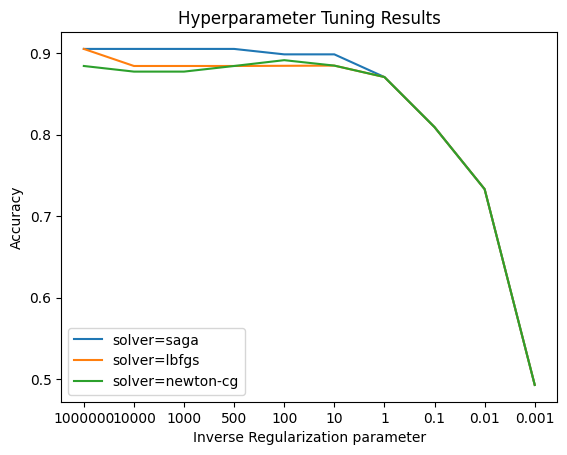

In [33]:
plt.plot(c_,saga_avg_accs,label='solver=saga')
plt.plot(c_,lbfgs_avg_accs,label='solver=lbfgs')
plt.plot(c_,newton_avg_accs,label='solver=newton-cg')
plt.xlabel('Inverse Regularization parameter')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Hyperparameter Tuning Results')
plt.show()

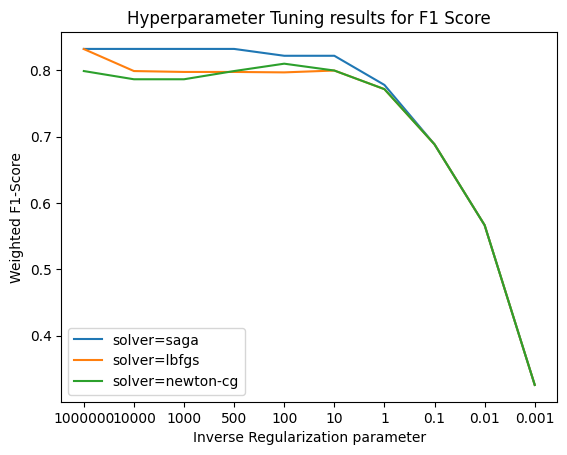

In [35]:
plt.plot(c_,saga_avg_f1,label='solver=saga')
plt.plot(c_,lbfgs_avg_f1,label='solver=lbfgs')
plt.plot(c_,newton_avg_f1,label='solver=newton-cg')
plt.xlabel('Inverse Regularization parameter')
plt.ylabel('Weighted F1-Score')
plt.legend()
plt.title('Hyperparameter Tuning results for F1 Score')
plt.show()

### Testing 

In [11]:
best_model = LogisticRegression(C=500,solver='saga')
best_model.fit(X_train_normalized,y_train)

y_pred = best_model.predict(X_test_normalized)
dt_metrics = metrics.metrics(y_test,y_pred)
precisions,recalls,f1_scores,macro_f1,weighted_f1 = dt_metrics.f1_score()
acc = dt_metrics.compute_accuracy()

c:\Users\medha\anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [44]:
print('\n Accuracy:',acc)
print('\n f1 scores:',f1_scores)
print('\n weighted f1-score:',weighted_f1)
print('\n precisions:',precisions)
print('\n recalls:',recalls)
print('\n macro f1:',macro_f1)


 Accuracy: 0.8918918918918919

 f1 scores: [0.918918918918919, 0.3333333333333333, 0.967741935483871]

 weighted f1-score: 0.8235428104652168

 precisions: [0.9444444444444444, 0.25, 1.0]

 recalls: [0.8947368421052632, 0.5, 0.9375]

 macro f1: 0.7399980625787078


## INTERPRETABILITY

In [8]:
## 1. LOOK AT THE COEFFICIENTS TO SEE THE FEATURE IMPORTANCE SCORES
coefficents = best_model.coef_ 
class0_coef = coefficents[0]
class1_coef = coefficents[1]
class2_coef = coefficents[2]

## setting a threshold of 1 to view only the important variables
thresholded_class0 = []
thresholded_col = []
for coef,col in zip(class0_coef,X_train.columns):
    if np.abs(coef) >= 1:
        thresholded_class0.append(coef)
        thresholded_col.append(col)

thresholded_class1 = []
thresholded_col1 = []
for coef,col in zip(class1_coef,X_train.columns):
    if np.abs(coef) >= 1:
        thresholded_class1.append(coef)
        thresholded_col1.append(col)


thresholded_class2 = []
thresholded_col2 = []
for coef,col in zip(class2_coef,X_train.columns):
    if np.abs(coef) >= 1:
        thresholded_class2.append(coef)
        thresholded_col2.append(col)

In [10]:
unique_values_all = np.union1d(np.union1d(thresholded_col2, thresholded_col1), thresholded_col)
len(unique_values_all)

46

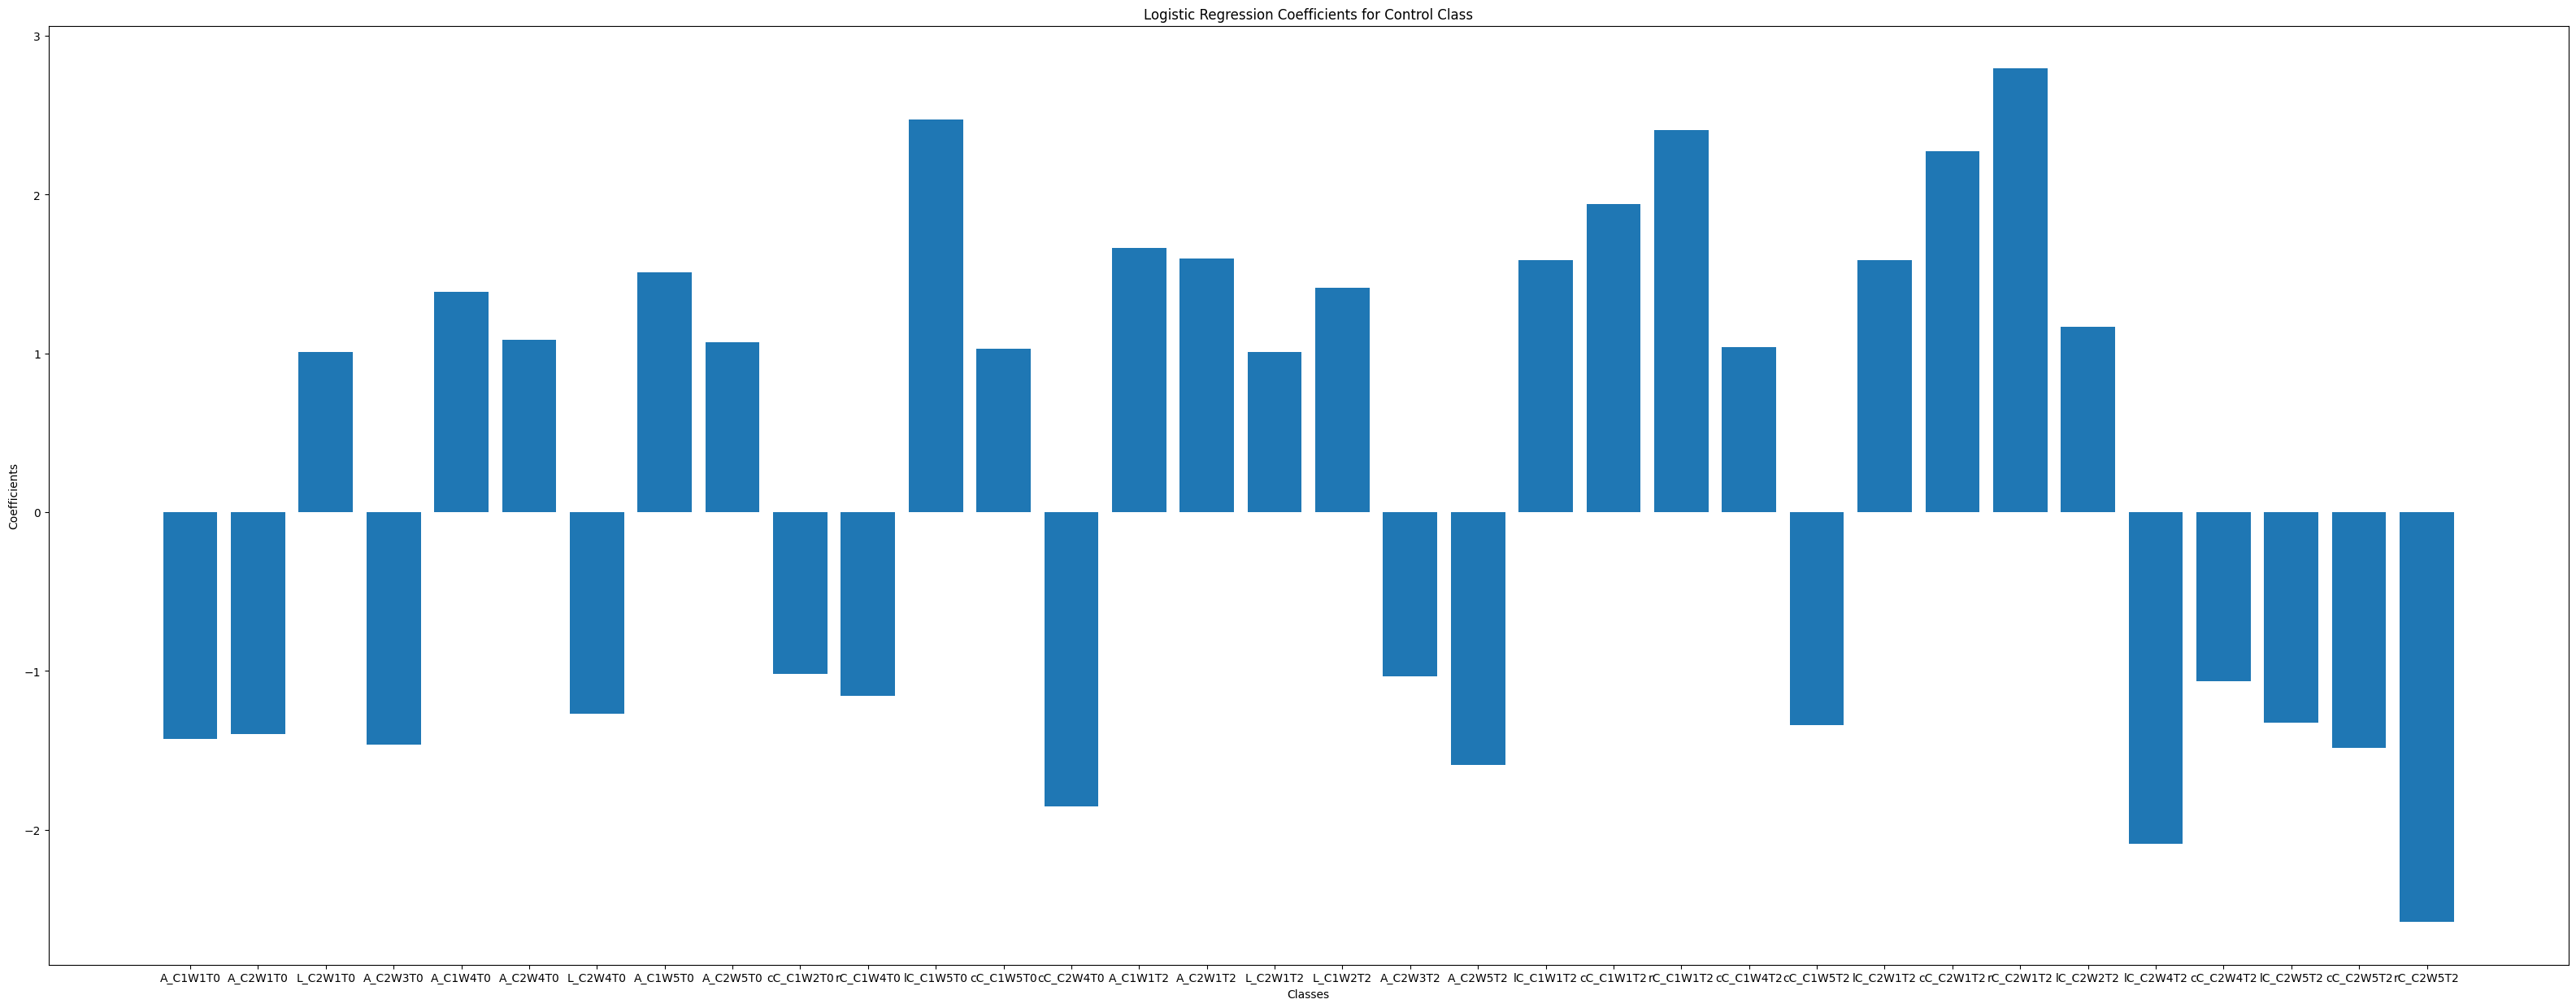

In [61]:
# Plotting as a bar graph
plt.figure(figsize=(40, 15))
plt.bar(thresholded_col, thresholded_class0)
plt.xlabel('Classes')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Coefficients for Control Class')
plt.show()


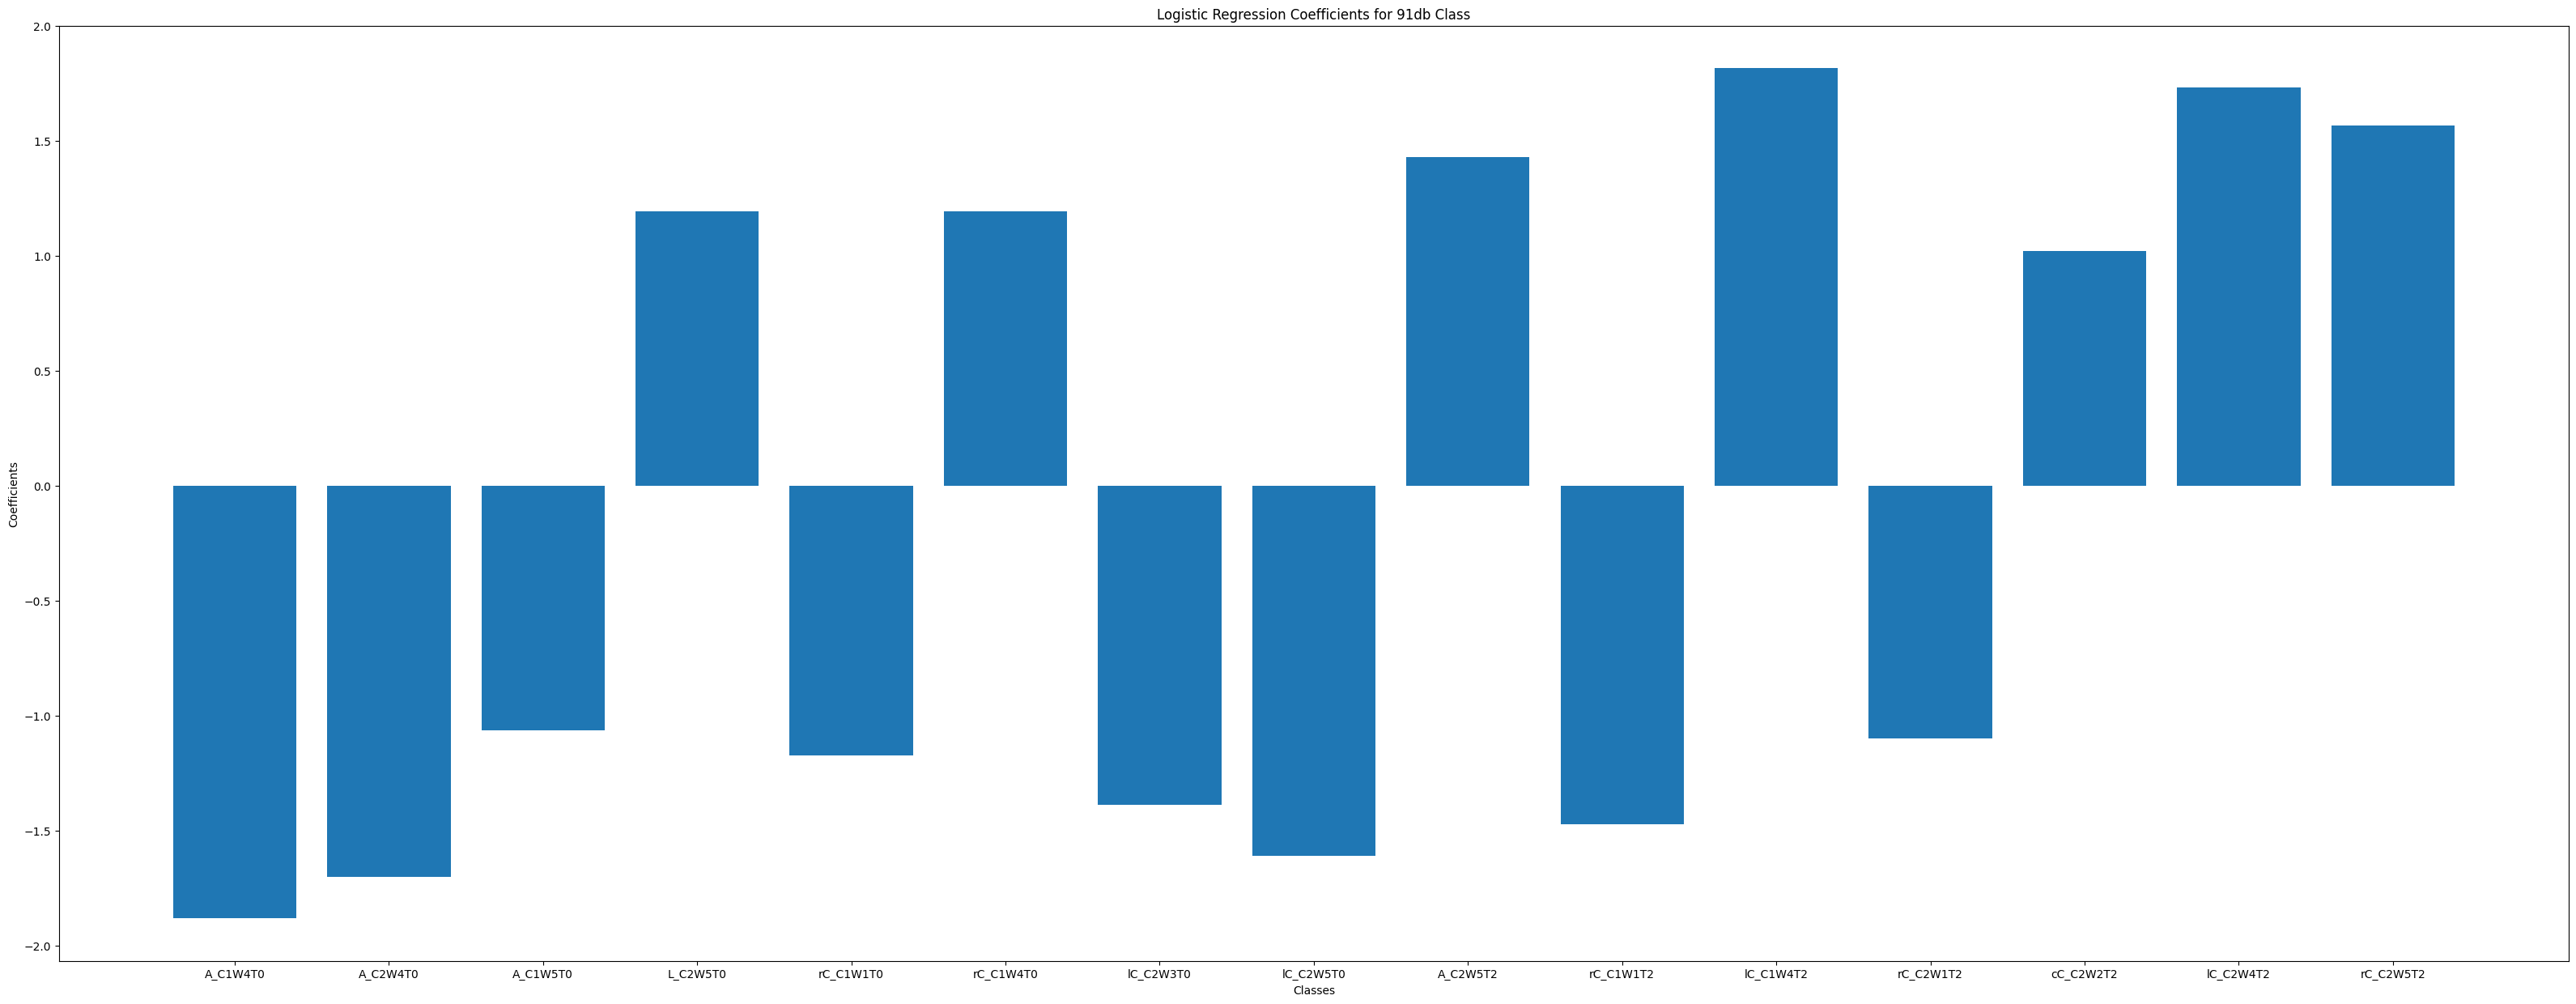

In [67]:
# Plotting as a bar graph
plt.figure(figsize=(40, 15))
plt.bar(thresholded_col1, thresholded_class1)
plt.xlabel('Classes')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Coefficients for 91db Class')
plt.show()


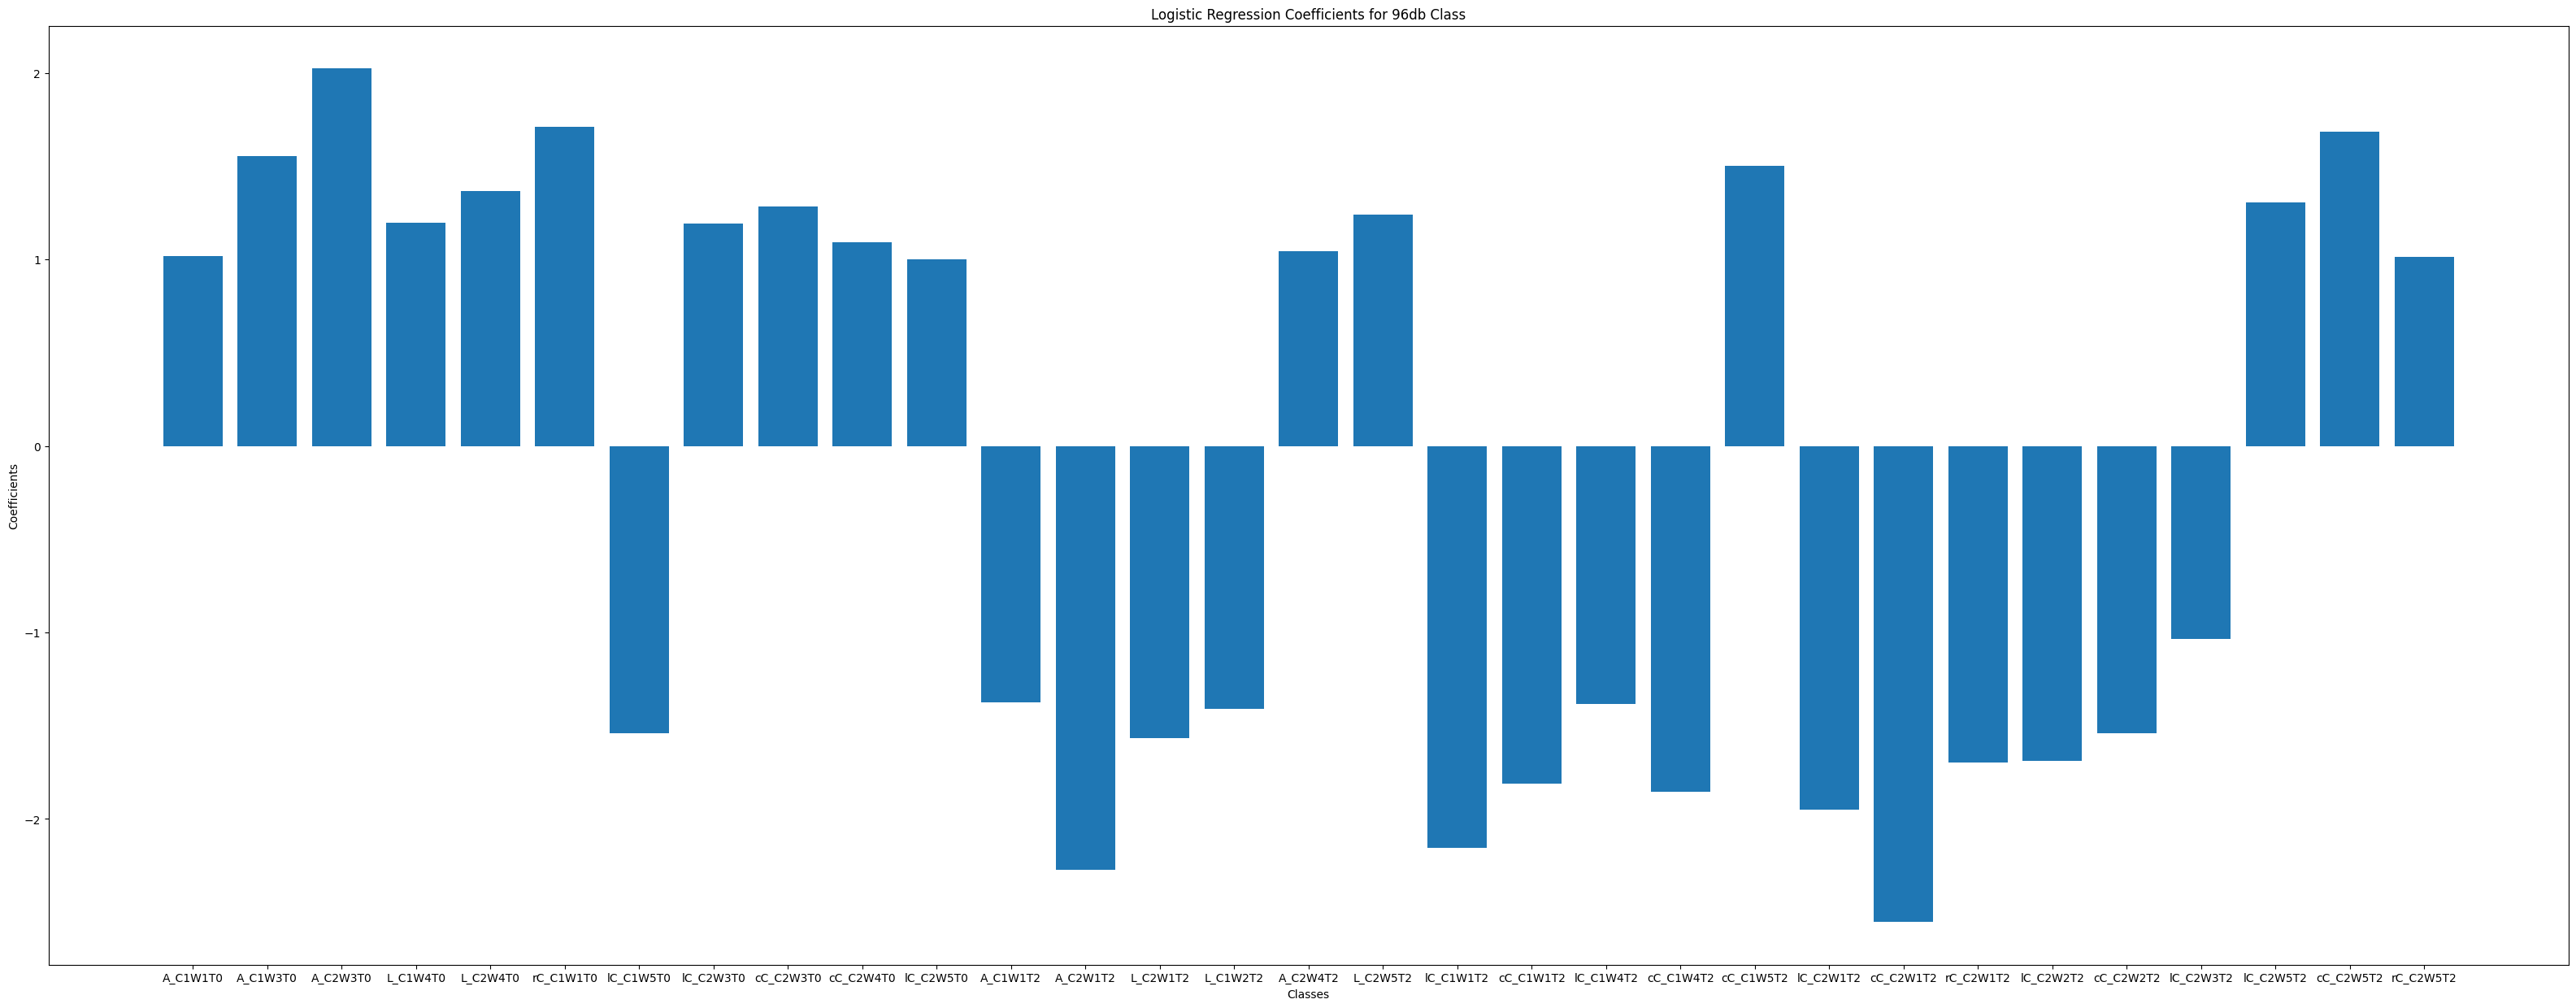

In [69]:
# Plotting as a bar graph
plt.figure(figsize=(40, 15))
plt.bar(thresholded_col2, thresholded_class2)
plt.xlabel('Classes')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Coefficients for 96db Class')
plt.show()


In [75]:
## class 0 top 10 coefficients 
sorted_indices = np.argsort(thresholded_class0)[::-1]
thresholded_col = np.array(thresholded_col)
top_10_class0_features = thresholded_col[sorted_indices]
top_10_class0 = {thresholded_col[index]:thresholded_class0[index] for index in sorted_indices[:10]}
top_10_class0

{'rC_C2W1T2': 2.794678539067706,
 'lC_C1W5T0': 2.474341699516395,
 'rC_C1W1T2': 2.4060256444016357,
 'cC_C2W1T2': 2.273963997871544,
 'cC_C1W1T2': 1.939397591322842,
 'A_C1W1T2': 1.6658451997845731,
 'A_C2W1T2': 1.5966930064248919,
 'lC_C1W1T2': 1.5860878829698057,
 'lC_C2W1T2': 1.5843753837189818,
 'A_C1W5T0': 1.5091884300137874}

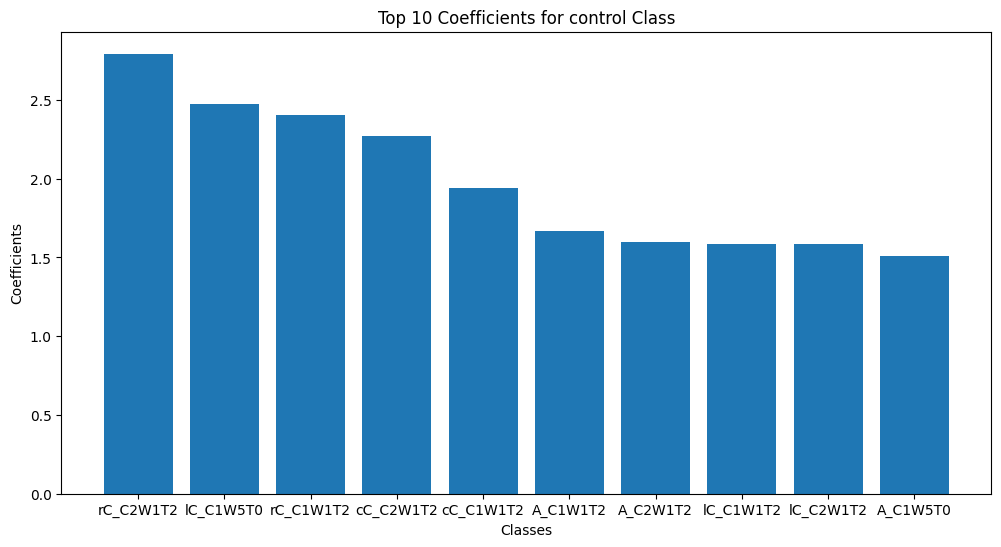

In [86]:
# Plotting as a bar graph
plt.figure(figsize=(12, 6))
plt.bar(top_10_class0.keys(), top_10_class0.values())
plt.xlabel('Classes')
plt.ylabel('Coefficients')
plt.title('Top 10 Coefficients for control Class')
plt.show()


In [77]:
## class 1 top 10 coefficients 
sorted_indices = np.argsort(thresholded_class1)[::-1]
thresholded_col1 = np.array(thresholded_col1)
top_10_class1 = {thresholded_col1[index]:thresholded_class1[index] for index in sorted_indices[:10]}
top_10_class1

{'lC_C1W4T2': 1.8156107571910516,
 'lC_C2W4T2': 1.730252565903802,
 'rC_C2W5T2': 1.567115225406056,
 'A_C2W5T2': 1.4279379742317633,
 'rC_C1W4T0': 1.1938535227699938,
 'L_C2W5T0': 1.1934587252136681,
 'cC_C2W2T2': 1.0215326059492813,
 'A_C1W5T0': -1.0640988087253815,
 'rC_C2W1T2': -1.0983488974763973,
 'rC_C1W1T0': -1.1716849415388877}

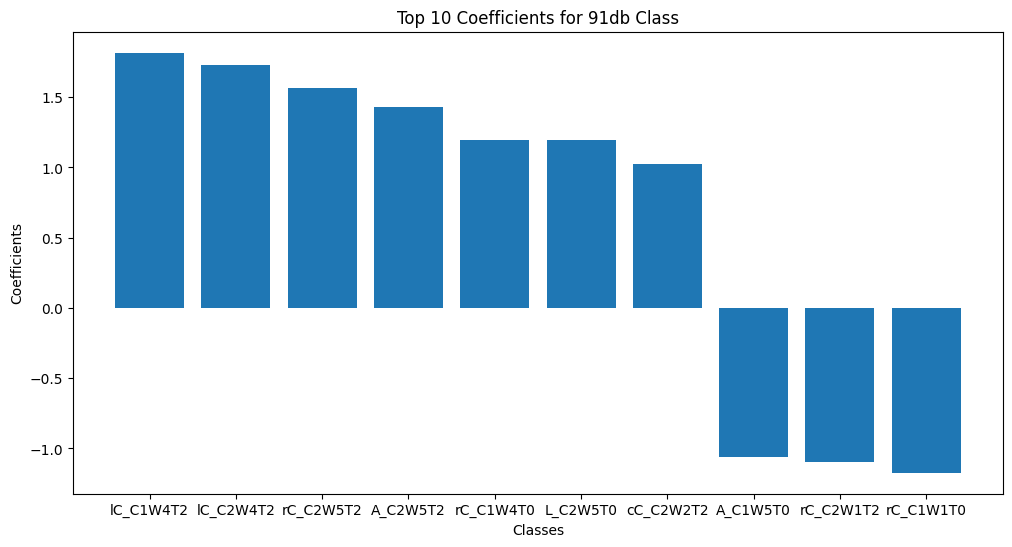

In [87]:
# Plotting as a bar graph
plt.figure(figsize=(12, 6))
plt.bar(top_10_class1.keys(), top_10_class1.values())
plt.xlabel('Classes')
plt.ylabel('Coefficients')
plt.title('Top 10 Coefficients for 91db Class')
plt.show()


In [78]:
## class 2 top 10 coefficients 
sorted_indices = np.argsort(thresholded_class2)[::-1]
thresholded_col2 = np.array(thresholded_col2)
top_10_class2 = {thresholded_col2[index]:thresholded_class2[index] for index in sorted_indices[:10]}
top_10_class2

{'A_C2W3T0': 2.0240977838696774,
 'rC_C1W1T0': 1.7109447589839533,
 'cC_C2W5T2': 1.6852526990444059,
 'A_C1W3T0': 1.5520438516471609,
 'cC_C1W5T2': 1.5012723620235757,
 'L_C2W4T0': 1.364244540350509,
 'lC_C2W5T2': 1.305480373949792,
 'cC_C2W3T0': 1.28353188967895,
 'L_C2W5T2': 1.2388040926571962,
 'L_C1W4T0': 1.198329805744829}

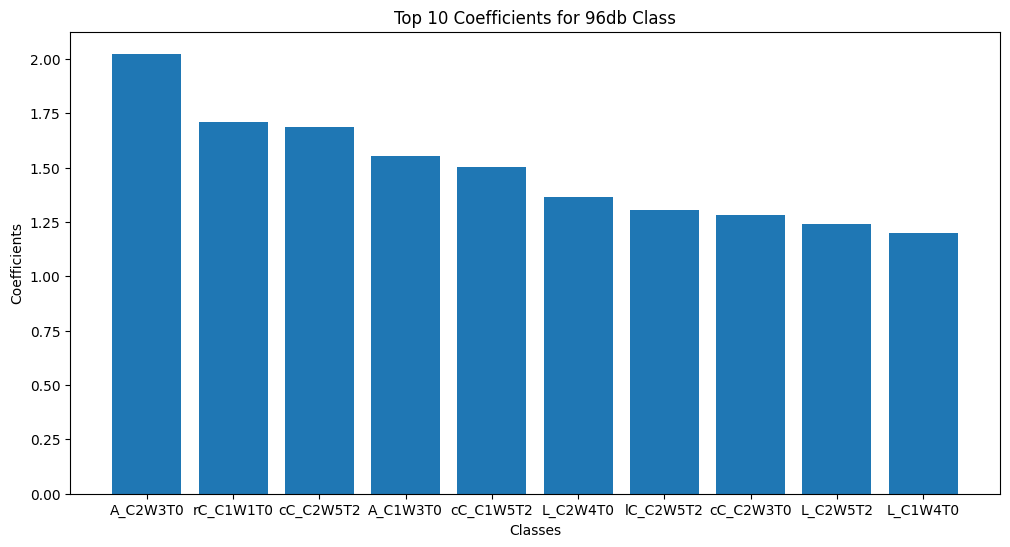

In [88]:
# Plotting as a bar graph
plt.figure(figsize=(12, 6))
plt.bar(top_10_class2.keys(), top_10_class2.values())
plt.xlabel('Classes')
plt.ylabel('Coefficients')
plt.title('Top 10 Coefficients for 96db Class')
plt.show()


## VARIABLE IMPORTANCE 

In [12]:
from sklearn.inspection import permutation_importance

In [13]:
## this follows the same method as model reliance calculation the distribution of the feature is messed up before prediction
result = permutation_importance(best_model, X_test_normalized, y_test, n_repeats=10,random_state=42)

In [14]:
important_variables_lr = {i:value for i,value in enumerate(result['importances_mean']) if value > 0}
important_var_indices = np.array([key for key,val in important_variables_lr.items()])
importance_scores = np.array([val for key,val in important_variables_lr.items()])

In [15]:
sorted_indices = np.argsort(importance_scores)[::-1]
sorted_scores = importance_scores[sorted_indices]

In [16]:
sorted_scores

array([0.02972973, 0.02162162, 0.01891892, 0.01621622, 0.01621622,
       0.01351351, 0.01351351, 0.01081081, 0.00810811, 0.00540541,
       0.00540541, 0.0027027 ])

In [17]:
features = X_test_normalized.columns
sorted_feature_indices = important_var_indices[sorted_indices]
sorted_features = features[sorted_feature_indices]

In [18]:
sorted_features

Index(['cC_C2W1T2', 'A_C2W1T2', 'cC_C1W1T2', 'lC_C1W1T2', 'rC_C2W5T2',
       'rC_C1W1T2', 'A_C1W1T2', 'lC_C2W1T2', 'cC_C1W4T2', 'lC_C2W5T2',
       'rC_C2W1T2', 'lC_C2W2T2'],
      dtype='object')

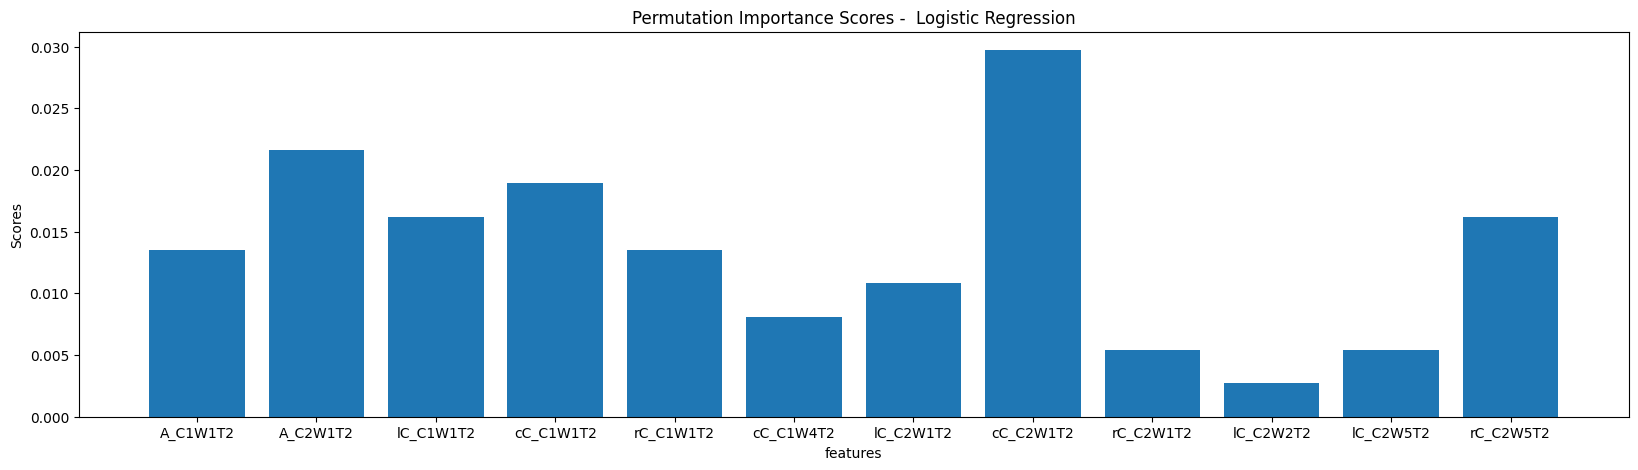

In [20]:
plt.figure(figsize=(20,5))
plt.bar(features[important_var_indices],importance_scores)
plt.xlabel('features')
plt.ylabel('Scores')
plt.title('Permutation Importance Scores -  Logistic Regression')
plt.show()
